In [10]:
import timeit
%pylab inline
#import iam_hdf5_iterator
import hdf5_iterator
reload(hdf5_iterator)
import CoffeeStainer
reload(CoffeeStainer)
from PIL import Image
import logging
logging.getLogger().setLevel(logging.INFO)
logging.getLogger('hdf5_iterator').setLevel(logging.INFO)
logging.getLogger('hdf5_iterator.viz_tools.array_to_png').setLevel(logging.INFO)
logging.getLogger('hdf5_iterator.minibatcher').setLevel(logging.INFO)

Populating the interactive namespace from numpy and matplotlib


In [15]:
def plot_shingles(batch, nr_to_plot, nr_per_row=3):
    nr_rows = nr_to_plot // nr_per_row + min(nr_to_plot % nr_per_row, 1)
    for row_i in range(nr_rows):
        for col_i in range(nr_per_row):
            subplot_cell_id = row_i * nr_per_row + col_i + 1
            # handle partial final row case
            if subplot_cell_id > nr_to_plot:
                break
            
            batch_img = batch[subplot_cell_id-1]
            
            plt.subplot(nr_rows, nr_per_row, subplot_cell_id)
            plt.imshow(-batch_img, cmap="gray")
            plt.gca().axes.get_xaxis().set_ticks([])
            plt.gca().axes.get_yaxis().set_ticks([])
            
    
    
def demo_nmec(nmec_hdf5,
        shingle_size=(110,60),
        batch_size=32,
        num_authors=50,
        num_forms_per_author=8,
        stdev_threshold=10.,
        add_rotation=True):
    print "NMEC Iteration Demo"
    #nmec_pre = hdf5_iterator.nmec_pre
    nmec_pre=None
    def nmec_post(x, **kwargs):
        stainer = CoffeeStainer.CoffeeStainer()
        x = stainer.get_rand_stain_w_random_brightness(Image.fromarray(x, 'L'), shingle_size, kwargs["rng"])
        x = hdf5_iterator.zero_one(x)
        #x = hdf5_iterator.noise_for_example(x, extent=100, intensity=0.2, **kwargs)

        return x
    
    nmec_iterator = hdf5_iterator.Hdf5MiniBatcher(nmec_hdf5, 
                         num_authors=num_authors, 
                         num_forms_per_author=num_forms_per_author,
                         shingle_dim=shingle_size,
                         batch_size=batch_size,
                         rng_seed=888,
                         preprocess=nmec_pre,
                         postprocess=nmec_post,
                         add_rotation=add_rotation,
                         stdev_threshold=stdev_threshold)    
    print "First batch: "
    mb = nmec_iterator.get_train_batch()
    plt.figure(figsize=(9,3))
    plot_shingles(mb[0], 18, 6)
    plt.show()
    print "Next batch: "
    mb2 = nmec_iterator.get_train_batch()
    plt.figure(figsize=(9,3))
    plot_shingles(mb2[0], 18, 6)
    plt.show()

        
def demo_iam(iam_hdf5,
             shingle_size=(120,120),
             batch_size=32,
             num_authors=100,
             num_forms_per_author=9):
    print "Sampling demo."
    print "Each batch should be different within iterations and identical across iterations."
    for iter_i in range(3):
        print "Iteration {0}.................".format(iter_i+1)
        iam_iterator = hdf5_iterator.Hdf5MiniBatcher(iam_hdf5, 
                         num_authors=num_authors, 
                         num_forms_per_author=num_forms_per_author,
                         shingle_dim=shingle_size,
                         batch_size=batch_size,
                         rng_seed=888)
    
        print "First batch: "
        get_t1 = time.clock()
        mb = iam_iterator.get_train_batch()
        get_t2 = time.clock()
        print "Time to retrieve: {0}".format(get_t2-get_t1)
        plt.figure(figsize=(9,3))
        plot_shingles(mb[0], 18, 6)
        plt.show()
        print "Next batch: "
        mb2 = iam_iterator.get_train_batch()
        plt.figure(figsize=(9,3))
        plot_shingles(mb2[0], 18, 6)
        plt.show()
        
    print "No repeats demo"
    print "The probability of a repeated shingle in a single epoch should be very small."
    iam_iterator = hdf5_iterator.Hdf5MiniBatcher(iam_hdf5, 
                     num_authors=num_authors, 
                     num_forms_per_author=num_forms_per_author,
                     shingle_dim=shingle_size,
                     batch_size=batch_size)
    nr_iters = 5
    unique_imgs = set()
    for i in range(nr_iters):
        print "Batch {0}".format(i)
        mb = iam_iterator.get_train_batch()
        plt.figure(figsize=(9,9))
        plot_shingles(mb[0], batch_size, 6)
        plt.show()
        unique_imgs.update([mb[0][img_i].tostring() for img_i in range(batch_size)])
        print "**Unique shingles so far: {0} (should be {1})**".format(len(unique_imgs), 
                                                                       (i+1) * batch_size)

def main():
    #demo_iam("/fileserver/iam/iam-processed/lines/author_lines.hdf5")
    demo_time = timeit.timeit(lambda: demo_nmec("/fileserver/nmec-handwriting/nmec_scaled_author_form.hdf5", 
                                                stdev_threshold=None, add_rotation=False, shingle_size=(200,200)), number=1)
    #demo_time = timeit.timeit(lambda: demo_nmec("/fileserver/nmec-handwriting/nmec.hdf5"), number=1)
    print "{0} seconds".format(demo_time)
        
    
       
    
    

NMEC Iteration Demo
First batch: 


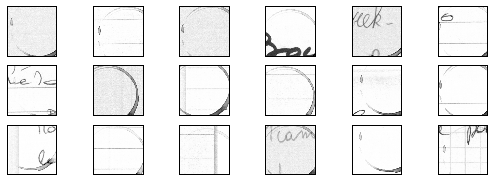

Next batch: 


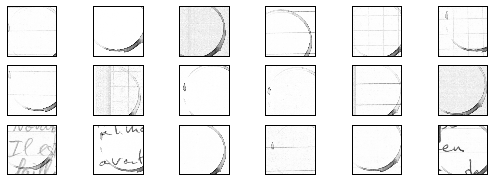

5.52231287956 seconds


In [16]:
# Main Test Cell
#%pdb on
main()